In [1]:
# Sample API
import flowx
import simulation
import numpy
flowx.__version__

'0.1.dev'

In [2]:
# Define grid parameters
nx, ny = 50, 50

xmin, xmax = 0.0, 2.0*numpy.pi
ymin, ymax = 0.0, 2.0*numpy.pi

step_max = 3
u_error_ = numpy.zeros(step_max)
v_error_ = numpy.zeros(step_max)
p_error_ = numpy.zeros(step_max)
dt = numpy.zeros(step_max)


# Define cell-centered variable names
center_vars = ['pres', 'divv', 'asol', 'eror']
face_vars   = ['velc', 'hvar', 'asol', 'eror']

# Define boundary conditions for variable pressure and velocity [left, right, bottom, top]
bc_type_pres = {'pres': ['neumann', 'neumann', 'neumann', 'neumann']}
bc_val_pres  = {'pres': [0.0, 0.0, 0.0, 0.0]}

bc_type_u = {'velc': ['dirichlet', 'dirichlet', 'dirichlet', 'dirichlet']}
bc_val_u  = {'velc': [0.0, 0.0, 0.0, 0.0]}

bc_type_v = {'velc': ['dirichlet', 'dirichlet', 'dirichlet', 'dirichlet']}
bc_val_v  = {'velc': [0.0, 0.0, 0.0, 0.0]}

# Create the grid and data
gridc = flowx.Grid('cell-centered', center_vars,
                    nx, ny, xmin, xmax, ymin, ymax,
                    user_bc_type=bc_type_pres, user_bc_val=bc_val_pres)

gridx = flowx.Grid('x-face', face_vars,
                    nx, ny, xmin, xmax, ymin, ymax,
                    user_bc_type=bc_type_u, user_bc_val=bc_val_u)

gridy = flowx.Grid('y-face', face_vars,
                    nx, ny, xmin, xmax, ymin, ymax,
                    user_bc_type=bc_type_v, user_bc_val=bc_val_v)

for j in range (1,step_max+1):

    scalars = flowx.Scalars(tmax=2, dt=0.01/j, Re=1.0)

    simulation.update_bc_val(gridx, gridy, 'velc', scalars.variable['to'])
    simulation.get_initial(gridc, gridx, gridy, 'velc', 'pres')
    

 
    ins_vars = ['velc', 'hvar', 'divv', 'pres']

    poisson_options = dict(maxiter = 2000, tol = 1e-9)
    poisson_options['lu'], poisson_options['mtx'] = flowx.poisson.build_sparse(gridc, 'pres')

    while scalars.variable['time'] <= scalars.variable['tmax']:
    
        for i in range(0,3):
        
            # Update the time-dependent boundary condition value
            simulation.update_bc_val(gridx, gridy, 'velc', scalars.variable['time'])

            # Predictor Step
            flowx.ins.rk3(gridc, gridx, gridy, scalars, ins_vars, 'predictor', i=i)

            # Divergence Step
            flowx.ins.rk3(gridc, gridx, gridy, scalars, ins_vars, 'divergence', i=i)

            # Solve the pressure Poisson equation 
            scalars.stats['ites'], scalars.stats['res'] = flowx.poisson.solve_lu(gridc, 'pres', 'divv', 
                                                                                        poisson_options)
            # Corrector Step
            flowx.ins.rk3(gridc, gridx, gridy, scalars, ins_vars, 'corrector', i=i)

        # Display stats
        if scalars.variable['nstep'] % 10 == 0:
            flowx.io.display_stats(scalars)   

        scalars.advance()
    
    
    simulation.get_analytical(gridc, gridx, gridy, 'asol', scalars.variable['time']) 
    
    
    gridx.get_error('eror','velc','asol')
    gridy.get_error('eror','velc','asol')
    gridc.get_error('eror','pres','asol')


    u_error = gridx.get_l_max('eror')
    v_error = gridy.get_l_max('eror')
    p_error = gridc.get_l_max('eror')
    
    
    u_error_[j-1] = u_error
    v_error_[j-1] = v_error
    p_error_[j-1] = p_error
    dt[j-1]=0.01/j

------------ Time = 0.0 ---------------
Number of poisson iterations    : None
Final poisson residual : 1.095489111703342e-12
Max, Min, U   : 1.0, -1.0
Max, Min, V   : 1.0, -1.0
Max, Min, P   : 1.599717700688447, -1.6139361171531426
Max, Min, DIV : 2.9976021664879227e-15, -3.164135620181696e-15


------------ Time = 0.09999999999999999 ---------------
Number of poisson iterations    : None
Final poisson residual : 8.529757889399014e-13
Max, Min, U   : 0.8187307530779818, -0.8187307530779818
Max, Min, V   : 0.8187307530779818, -0.8187307530779818
Max, Min, P   : 1.3187598003420857, -1.185249070861713
Max, Min, DIV : 2.6645352591003757e-15, -2.6645352591003757e-15


------------ Time = 0.20000000000000004 ---------------
Number of poisson iterations    : None
Final poisson residual : 6.729275363757588e-13
Max, Min, U   : 0.6703200460356392, -0.6703200460356392
Max, Min, V   : 0.6703200460356392, -0.6703200460356392
Max, Min, P   : 1.0113292365177995, -1.0298611548545222
Max, Min, DIV : 2

------------ Time = 0.2500000000000001 ---------------
Number of poisson iterations    : None
Final poisson residual : 6.450541321746215e-13
Max, Min, U   : 0.6065306597126333, -0.6065306597126333
Max, Min, V   : 0.6065306597126333, -0.6065306597126333
Max, Min, P   : 0.7840735523276474, -1.0437567550281213
Max, Min, DIV : 2.4980018054066022e-15, -2.1649348980190553e-15


------------ Time = 0.30000000000000016 ---------------
Number of poisson iterations    : None
Final poisson residual : 5.539497012962763e-13
Max, Min, U   : 0.5488116360940263, -0.5488116360940263
Max, Min, V   : 0.5488116360940263, -0.5488116360940263
Max, Min, P   : 0.9115922560282109, -0.7417657054149442
Max, Min, DIV : 2.248201624865942e-15, -2.581268532253489e-15


------------ Time = 0.3500000000000002 ---------------
Number of poisson iterations    : None
Final poisson residual : 4.85175898306954e-13
Max, Min, U   : 0.4965853037914093, -0.4965853037914093
Max, Min, V   : 0.4965853037914093, -0.4965853037914093

------------ Time = 1.49999999999999 ---------------
Number of poisson iterations    : None
Final poisson residual : 4.470986784625571e-14
Max, Min, U   : 0.04978706836786494, -0.04978706836786494
Max, Min, V   : 0.04978706836786494, -0.04978706836786494
Max, Min, P   : 0.0751452220780351, -0.07432851767170424
Max, Min, DIV : 1.6653345369377348e-16, -1.6653345369377348e-16


------------ Time = 1.549999999999989 ---------------
Number of poisson iterations    : None
Final poisson residual : 4.3354113405595647e-14
Max, Min, U   : 0.0450492023935588, -0.0450492023935588
Max, Min, V   : 0.0450492023935588, -0.0450492023935588
Max, Min, P   : 0.06453719144456663, -0.07068998379514538
Max, Min, DIV : 1.6653345369377348e-16, -1.6653345369377348e-16


------------ Time = 1.5999999999999879 ---------------
Number of poisson iterations    : None
Final poisson residual : 3.950240991798539e-14
Max, Min, U   : 0.040762203978367204, -0.040762203978367204
Max, Min, V   : 0.040762203978367204, -0.040

------------ Time = 0.4333333333333342 ---------------
Number of poisson iterations    : None
Final poisson residual : 4.081458118750833e-13
Max, Min, U   : 0.42035038450868123, -0.42035038450868123
Max, Min, V   : 0.42035038450868123, -0.42035038450868123
Max, Min, P   : 0.5849985352014756, -0.679580252352528
Max, Min, DIV : 1.3322676295501878e-15, -1.4155343563970746e-15


------------ Time = 0.46666666666666773 ---------------
Number of poisson iterations    : None
Final poisson residual : 3.86213228433416e-13
Max, Min, U   : 0.3932407208685974, -0.3932407208685974
Max, Min, V   : 0.3932407208685974, -0.3932407208685974
Max, Min, P   : 0.5304551336182495, -0.6524877851119392
Max, Min, DIV : 1.3322676295501878e-15, -1.3322676295501878e-15


------------ Time = 0.5000000000000012 ---------------
Number of poisson iterations    : None
Final poisson residual : 3.5918787803271286e-13
Max, Min, U   : 0.36787944117144145, -0.36787944117144145
Max, Min, V   : 0.36787944117144145, -0.3678794

------------ Time = 1.2666666666666688 ---------------
Number of poisson iterations    : None
Final poisson residual : 7.394823242287634e-14
Max, Min, U   : 0.07939393227707787, -0.07939393227707787
Max, Min, V   : 0.07939393227707787, -0.07939393227707787
Max, Min, P   : 0.12518548176063454, -0.1133838777956382
Max, Min, DIV : 3.0184188481996443e-16, -3.3306690738754696e-16


------------ Time = 1.300000000000003 ---------------
Number of poisson iterations    : None
Final poisson residual : 7.50611051558936e-14
Max, Min, U   : 0.07427357821433345, -0.07427357821433345
Max, Min, V   : 0.07427357821433345, -0.07427357821433345
Max, Min, P   : 0.09797291248202696, -0.12519971920182613
Max, Min, DIV : 3.434752482434078e-16, -3.122502256758253e-16


------------ Time = 1.333333333333337 ---------------
Number of poisson iterations    : None
Final poisson residual : 7.099582409873696e-14
Max, Min, U   : 0.06948345122280102, -0.06948345122280102
Max, Min, V   : 0.06948345122280102, -0.06948

<IPython.core.display.Javascript object>


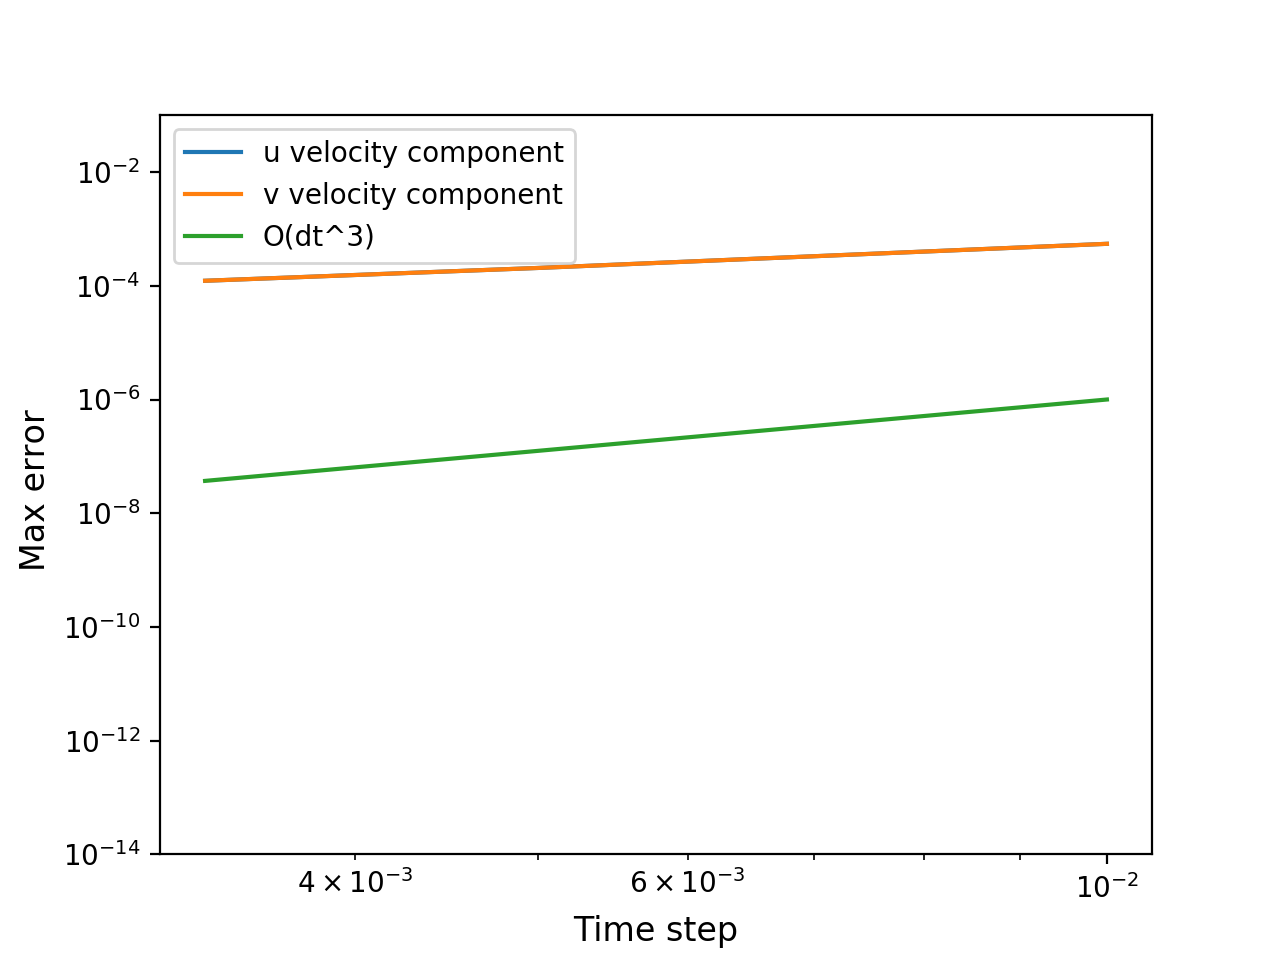

In [4]:
import matplotlib.pyplot as plt
#plt.loglog(u_error_, dt)
#plt.loglog(v_error_, dt)
plt.loglog(dt, u_error_, label = 'u velocity component')
plt.loglog(dt, v_error_, label= 'v velocity component')
plt.loglog(dt, dt**3,label= 'O(dt^3)')
plt.ylim(10**-14, 10**-1)
plt.xlabel("Time step", fontsize = 12)
plt.ylabel("Max error ", fontsize = 12)
plt.legend()